In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [3]:
with open('data/instances_train2017.json', 'r') as fin:
    data = json.load(fin)

categories = {k['id']: k['name'] for k in data['categories']}
categories

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

In [6]:
df = pd.DataFrame.from_records([{'image_id': k['image_id'], 'label': categories[k['category_id']]} for k in data['annotations']])
df.head()

,image_id,label
0,558840,hot dog
1,200365,hot dog
2,200365,hot dog
3,200365,hot dog
4,200365,hot dog


In [7]:
df['label'] = df['label'].str.replace(' ', '_')

In [9]:
df['image_id'].nunique()

117266

In [12]:
docs = df.groupby('image_id')['label'].apply(lambda x: ' '.join(x)).values

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [14]:
count_vect = CountVectorizer()
X = count_vect.fit_transform(docs)

In [15]:
X

<117266x80 sparse matrix of type '<class 'numpy.int64'>'
	with 342996 stored elements in Compressed Sparse Row format>

In [25]:
lda = LatentDirichletAllocation(n_jobs=-1)
topics = lda.fit_transform(X)

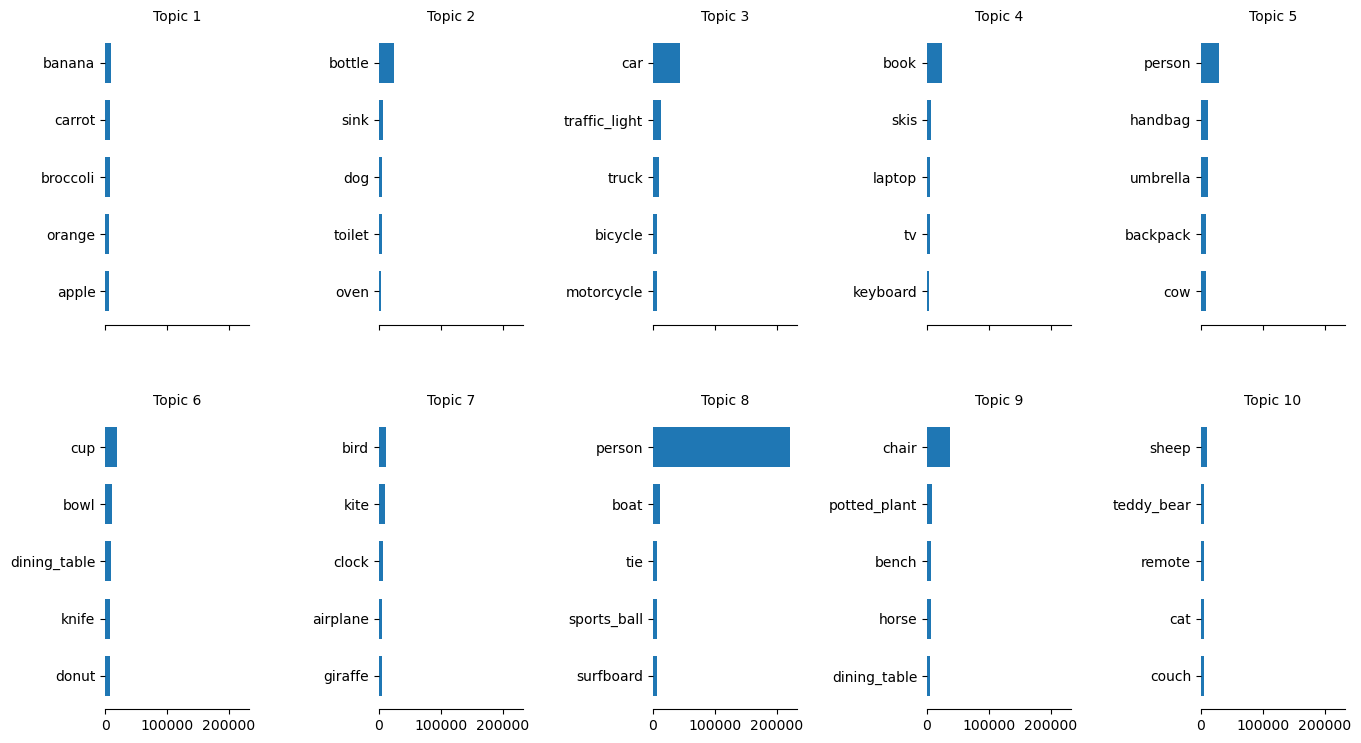

In [31]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(16, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 10})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=8)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plot_top_words(lda, count_vect.get_feature_names_out(), 5, '')

In [35]:
# Topic 1 - fruits and vegetables
# Topic 3 - traffic
# Topic 6 - Dining
keep = ['banana', 'carrot', 'broccoli', 'organge', 'apple', 'cup', 'bowl', 'dining_table', 'knife', 'car', 'traffic_light', 'truck', 'bicycle', 'motorcycle']
len(keep)

14

In [39]:
xdf = df[df['label'].isin(keep)]

In [40]:
xdf.head()

,image_id,label
2014,554445,dining_table
2015,520124,dining_table
2016,92998,dining_table
2017,340511,dining_table
2018,318361,dining_table


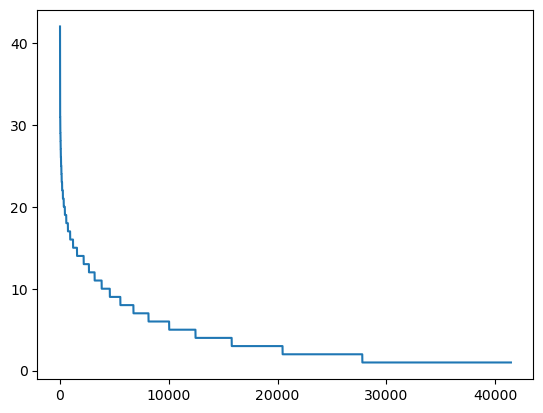

In [44]:
plt.plot(xdf['image_id'].value_counts().values)

In [45]:
docs = xdf.groupby('image_id')['label'].apply(lambda x: ' '.join(x)).values

count_vect = CountVectorizer()
X = count_vect.fit_transform(docs)

lda = LatentDirichletAllocation(n_jobs=-1)
topics = lda.fit_transform(X)

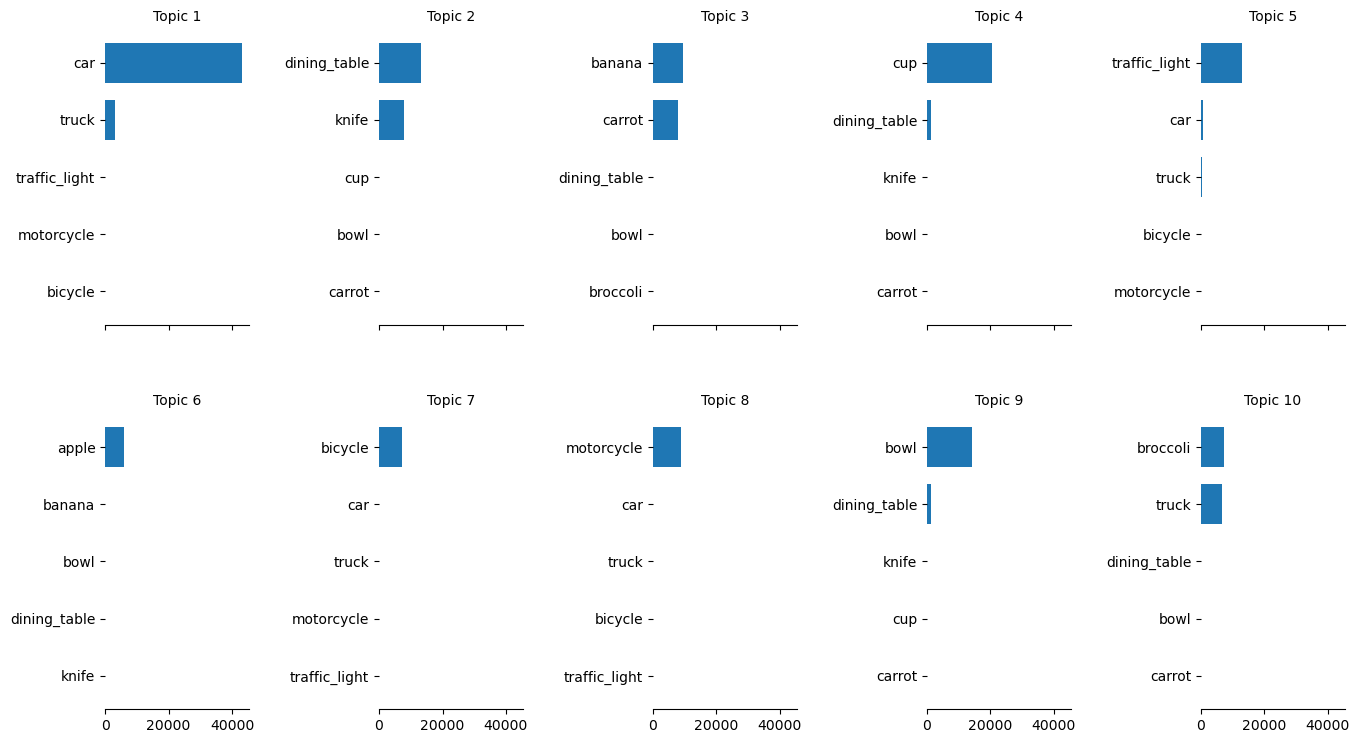

In [46]:
plot_top_words(lda, count_vect.get_feature_names_out(), 5, '')

In [47]:
keep = ['dining_table', 'knife', 'banana', 'carrot', 'cup', 'apple', 'bowl', 'broccoli']
xdf[xdf['label'].isin(keep)]['image_id'].nunique()

22675

In [53]:
xdf = df[df['label'].isin(keep)]

In [62]:
vc = xdf['image_id'].value_counts()
imids = vc[vc > 1]
imids = imids[imids < 10]
imids

508592    9
566336    9
497444    9
427823    9
44079     9
         ..
61838     2
235843    2
6800      2
128256    2
405261    2
Name: image_id, Length: 12404, dtype: int64

<AxesSubplot:>

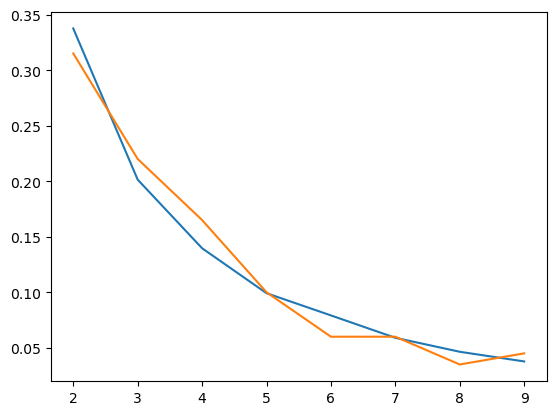

In [74]:
ax = imids.value_counts(normalize=True).sort_index().plot()
imids.sample(200).value_counts(normalize=True).sort_index().plot(ax=ax)

In [78]:
imids = imids.sample(200).index.tolist()

In [80]:
final = df[df['image_id'].isin(imids)]

<AxesSubplot:>

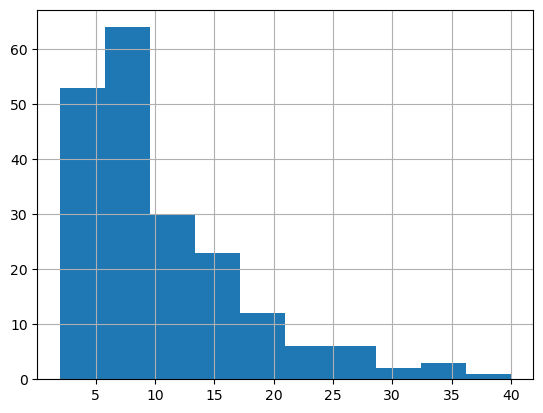

In [87]:
final.groupby('image_id')['label'].count().hist()

In [92]:
final = final[final['label'].isin(keep)]

In [93]:
final

,image_id,label
5965,274262,dining_table
9304,414156,cup
9370,414156,cup
9402,264347,cup
9445,136780,cup
...,...,...
848745,84757,cup
848922,218775,cup
849258,358484,bowl
851100,578250,dining_table


In [96]:
with open('data/sample.json', 'w') as fout:
    json.dump({'image_ids': final['image_id'].tolist(), 'labels': df['label'].unique().tolist()}, fout, indent=2)